# Analysis of one-year trace of gut microbiome
This notebook records the code used for analyzing data from [Gibbons _et. al._ (2017)](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005364). 

## Load required packages

In [1]:
## https://gist.github.com/stevenworthington/3178163
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c("ggplot2", "foreach",'doMC','lokern', 'pspline', 'monomvn', 
              "reshape2", "RColorBrewer", "grid", "RCurl", "igraph", "ggsci")
ipak(packages)

Loading required package: ggplot2
Loading required package: foreach
Loading required package: doMC
Loading required package: iterators
Loading required package: parallel
Loading required package: lokern
Loading required package: pspline
Loading required package: monomvn
Loading required package: pls

Attaching package: ‘pls’

The following object is masked from ‘package:stats’:

    loadings

Loading required package: lars
Loaded lars 1.2

Loading required package: MASS
Loading required package: reshape2
Loading required package: RColorBrewer
Loading required package: grid
Loading required package: RCurl
Loading required package: bitops
Loading required package: igraph
Warning message:
“package ‘igraph’ was built under R version 3.4.1”
Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: ggsci
Warning message:
“package ‘ggsci’ was built unde

ggplot2      foreach         doMC       lokern      pspline      monomvn 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
    reshape2 RColorBrewer         grid        RCurl       igraph        ggsci 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE

## Access Dropbox files

In [2]:
source.dropbox = function(dropbox.url, targetFile) {
    ### Adapted from http://rstudio-pubs-static.s3.amazonaws.com/10162_c939e11b01c54cc9afda69b4dd0c62fe.html
    library(RCurl)
    setwd(tempdir())
    destfile = targetFile
    # use regex to get the piece of the Dropbox URL we need
    matches <- regexpr("(/s/.*)", dropbox.url, perl = TRUE, ignore.case = TRUE)
    result <- attr(matches, "capture.start")[, 1]
    attr(result, "match.length") <- attr(matches, "capture.length")[, 1]
    dropbox.tail = regmatches(dropbox.url, result)
    dburl = paste("https://dl.dropbox.com", dropbox.tail, sep = "")
    x = getBinaryURL(dburl, followlocation = TRUE, ssl.verifypeer = FALSE)
    writeBin(x, destfile, useBytes = TRUE)
}

## Download data (optional)
If you have downloaded the entire git repository, you can skip this step.

In [3]:
## DA
source.dropbox("https://www.dropbox.com/s/oa47p5ru9846ss7/DA.counts.txt", "~/beem/time_series_analysis/DA.counts.txt")
source.dropbox("https://www.dropbox.com/s/kq0nd849osoyavh/DA.metadata.txt", "~/beem/time_series_analysis/DA.metadata.txt")
## M3
source.dropbox("https://www.dropbox.com/s/34p46fs2wli3okh/M3.counts.txt", "~/beem/time_series_analysis/M3.counts.txt")
source.dropbox("https://www.dropbox.com/s/02gkmlbsrhjtb14/M3.metadata.txt", "~/beem/time_series_analysis/M3.metadata.txt")
## DB
source.dropbox("https://www.dropbox.com/s/mw9igdeq1qk68ru/DB.counts.txt", "~/beem/time_series_analysis/DB.counts.txt")
source.dropbox("https://www.dropbox.com/s/k46lx4n6shtfmfz/DB.metadata.txt", "~/beem/time_series_analysis/DB.metadata.txt")
## F4
source.dropbox("https://www.dropbox.com/s/ssgzghscrfu2bjh/F4.counts.txt", "~/beem/time_series_analysis/F4.counts.txt")
source.dropbox("https://www.dropbox.com/s/9wa0vn6e1sfm01d/F4.metadata.txt", "~/beem/time_series_analysis/F4.metadata.txt")

## otu annotation
source.dropbox("https://www.dropbox.com/s/iub977z7u3z86wg/all_otu_mapping.txt", "~/beem/time_series_analysis/all_out_mapping.txt")

## Load functions and data

In [3]:
source("~/beem/emFunctions.r")
input.da <- read.table('~/beem/time_series_analysis/DA.counts.txt', head=F, row.names=1)
metadata.da <- read.table('~/beem/time_series_analysis/DA.metadata.txt', head=T)

## For DB, point #74 has extremely high of one species and #180 is sampled too far from the previous time point
input.db <- read.table('~/beem/time_series_analysis/DB.counts.txt', head=F, row.names=1)[,-c(74,180)]
metadata.db <- read.table('~/beem/time_series_analysis/DB.metadata.txt', head=T)[-c(74,180),]

## For M3, data from 330:332 are too far from previous time point
input.m3 <- read.table('~/beem/time_series_analysis/M3.counts.txt', head=F, row.names=1)[,1:329] 
metadata.m3 <- read.table('~/beem/time_series_analysis/M3.metadata.txt', head=T)[1:329,]

input.f4 <- read.table('~/beem/time_series_analysis/F4.counts.txt', head=F, row.names=1) 
metadata.f4 <- read.table('~/beem/time_series_analysis/F4.metadata.txt', head=T)

## Run BEEM

### Individual DA

In [4]:
counts.da <- input.da[-1,]
colnames(counts.da) <- as.character(input.da[1,])
res.da <- EM(dat=counts.da,meta=metadata.da, dev=10, refSp = 4,  verbose=TRUE,
          min_iter=50, max_iter=100, epsilon = 0.5, 
          scaling = 10000, ncpu=4, seed=0)

Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 1.576376


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.00155961


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.001258853


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.001005867


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0004566781


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003904092


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003552452


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003340172


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003239667


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003228932


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003240881


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003257495


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003258076


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003272437


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003285598


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003284254


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003289471


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003286466


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003284428


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003290796


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003303497


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003315526


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003319208


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003321578


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003316979


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003310548


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003304926


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003295063


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003303842


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003298102


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003291099


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.000328559


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003293699


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003258259


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003252407


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.000333274


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003276137


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003253296


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003455523


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003287297


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003467681


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003418874


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003276804


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003301861


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003233906


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003266451


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003317827


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003555847


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003326588


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0004178564


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003436784


##########################
##Iteration 52
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.000555618


##########################
##Iteration 53
####solve alpha and beta (E step)


### Individual M3

In [5]:
counts.m3 <- input.m3[-1,]
colnames(counts.m3) <- as.character(input.m3[1,])
res.m3 <- EM(dat=counts.m3,meta=metadata.m3, refSp = 21,  verbose=TRUE,
          min_iter=50, max_iter=100, epsilon = 0.5, 
          scaling = 10000, ncpu=4, seed=0)

Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.03665556


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0282835


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02610599


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02559728


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0254319


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02525233


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02518454


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02520555


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02537396


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02541129


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02547658


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02545824


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02562904


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02560262


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02555286


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02561372


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02547616


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02552609


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02562336


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02549924


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02562267


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02547803


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02562861


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02567195


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02556955


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02562703


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02559838


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02568537


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02545869


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02577491


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02580279


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02572742


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02589275


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0257428


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02585262


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02590693


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02602459


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02604743


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02609833


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02607699


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02630651


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0262922


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02588745


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02620218


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02601742


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02602834


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0259593


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02597359


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02592227


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02630135


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02606705


##########################
##Iteration 52
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02636153


##########################
##Iteration 53
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02620276


##########################
##Iteration 54
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02629819


##########################
##Iteration 55
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02629145


##########################
##Iteration 56
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02623017


##########################
##Iteration 57
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02641411


##########################
##Iteration 58
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02623246


##########################
##Iteration 59
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02641207


##########################
##Iteration 60
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02637427


##########################
##Iteration 61
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0264018


##########################
##Iteration 62
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02637606


##########################
##Iteration 63
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02630564


##########################
##Iteration 64
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02648817


##########################
##Iteration 65
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02632204


##########################
##Iteration 66
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02654019


##########################
##Iteration 67
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02628329


##########################
##Iteration 68
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02676351


##########################
##Iteration 69
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0264934


##########################
##Iteration 70
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02659531


##########################
##Iteration 71
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02674362


##########################
##Iteration 72
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.026507


##########################
##Iteration 73
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02643293


##########################
##Iteration 74
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02682899


##########################
##Iteration 75
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02652398


##########################
##Iteration 76
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02656367


##########################
##Iteration 77
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02695958


##########################
##Iteration 78
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02652067


##########################
##Iteration 79
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02685021


##########################
##Iteration 80
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02658004


##########################
##Iteration 81
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02698242


##########################
##Iteration 82
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02682092


##########################
##Iteration 83
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02699825


##########################
##Iteration 84
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02683815


##########################
##Iteration 85
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02706064


##########################
##Iteration 86
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0270508


##########################
##Iteration 87
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0270326


##########################
##Iteration 88
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02708118


##########################
##Iteration 89
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02713022


##########################
##Iteration 90
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0271718


##########################
##Iteration 91
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02730089


##########################
##Iteration 92
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02717991


##########################
##Iteration 93
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02728071


##########################
##Iteration 94
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02724712


##########################
##Iteration 95
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0276082


##########################
##Iteration 96
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02738184


##########################
##Iteration 97
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02763655


##########################
##Iteration 98
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0275652


##########################
##Iteration 99
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02755019


##########################
##Iteration 100
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02759455


##########################


### Individual DB

In [6]:
counts.db <- input.db[-1,]
colnames(counts.db) <- as.character(input.db[1,])
res.db <- EM(dat=counts.db,meta=metadata.db, refSp = 2,  verbose=TRUE,
          min_iter=50, max_iter=100, epsilon = 0.5, 
          scaling = 10000, ncpu=4, seed=0)

Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 275401343


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01210394


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.005905737


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01030362


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.005307191


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0076601


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0433381


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008140826


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007656435


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008741997


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.00567597


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007436143


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007151821


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007377575


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008219234


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007895954


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008112222


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007944385


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007806714


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007796648


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.00778815


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007976239


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007325176


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008069576


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007573592


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007581239


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008479144


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007550566


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007603151


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008743927


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008394034


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006789908


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.00800655


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.009113648


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006337106


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006711507


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008154993


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007740049


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008016872


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007848153


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008422912


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008242952


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006723505


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008384659


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007290867


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007317139


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008510333


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007540618


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008436338


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007062896


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008841268


##########################
##Iteration 52
####solve alpha and beta (E step)


### Individual F4

In [7]:
counts.f4 <- input.f4[-1,]
colnames(counts.f4) <- as.character(input.f4[1,])
res.f4 <- EM(dat=counts.f4,meta=metadata.f4, refSp = 8,  verbose=TRUE,
          min_iter=50, max_iter=100, epsilon = 0.5, 
          scaling = 10000, ncpu=4, seed=0)

Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1457895


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01543588


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01282583


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01263809


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01251512


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01271023


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01240916


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01266045


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01209538


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01221476


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01272994


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01219408


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01222955


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01225251


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01238528


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01233072


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01283555


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01241311


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01233678


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01296467


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01241471


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01294214


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01249102


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0124588


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01306167


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01266983


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01258474


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01249729


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01287127


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01250753


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01249071


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01284544


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01245384


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01244459


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01285082


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01237329


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01286892


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01241101


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01242624


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01232343


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0123265


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01234328


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01225278


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01275915


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01229537


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01225697


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01234473


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01235951


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01254281


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01236331


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0123628


##########################
##Iteration 52
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01280712


##########################
##Iteration 53
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01244914


##########################
##Iteration 54
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01241146


##########################
##Iteration 55
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01236985


##########################
##Iteration 56
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01238306


##########################
##Iteration 57
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01239872


##########################
##Iteration 58
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01232317


##########################
##Iteration 59
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0127692


##########################
##Iteration 60
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01247512


##########################
##Iteration 61
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01236799


##########################
##Iteration 62
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01228137


##########################
##Iteration 63
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01229616


##########################
##Iteration 64
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0122304


##########################
##Iteration 65
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01217853


##########################
##Iteration 66
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0121921


##########################
##Iteration 67
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01213863


##########################
##Iteration 68
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01214704


##########################
##Iteration 69
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01214236


##########################
##Iteration 70
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01211641


##########################
##Iteration 71
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0120913


##########################
##Iteration 72
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01206399


##########################
##Iteration 73
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01208258


##########################
##Iteration 74
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0119366


##########################
##Iteration 75
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01201585


##########################
##Iteration 76
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01210718


##########################
##Iteration 77
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01201758


##########################
##Iteration 78
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01202495


##########################
##Iteration 79
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01197517


##########################
##Iteration 80
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01196128


##########################
##Iteration 81
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01193445


##########################
##Iteration 82
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01200423


##########################
##Iteration 83
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01203349


##########################
##Iteration 84
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01194562


##########################
##Iteration 85
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01193121


##########################
##Iteration 86
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01192502


##########################
##Iteration 87
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01216914


##########################
##Iteration 88
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01204727


##########################
##Iteration 89
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01197922


##########################
##Iteration 90
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01193998


##########################
##Iteration 91
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01197398


##########################
##Iteration 92
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01193566


##########################
##Iteration 93
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01189714


##########################
##Iteration 94
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01187688


##########################
##Iteration 95
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01187175


##########################
##Iteration 96
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0118719


##########################
##Iteration 97
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01193809


##########################
##Iteration 98
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01187231


##########################
##Iteration 99
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01176975


##########################
##Iteration 100
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01182747


##########################


## Infer parameters

In [8]:
params.da <- paramFromEM(res.da, counts.da, metadata.da, ncpu=4)
params.m3 <- paramFromEM(res.m3, counts.m3, metadata.m3, ncpu=4)
params.db <- paramFromEM(res.db, counts.db, metadata.db, ncpu=4)
params.f4 <- paramFromEM(res.f4, counts.f4, metadata.f4, ncpu=4)

## Functions for analysis

In [9]:
getbiomass <- function(res){
    trace.mse <- res$trace.mse
    min.mse <- min(trace.mse)
    em.idx <- which((trace.mse-min.mse) < res$epsilon*min.mse)
    biomass <- apply(res$trace.biomass[,em.idx],1,median)
    biomass
}
int.net <- function(counts, parms, sig=1, title){
    ## plot interaction network
    minmax <- function(x) (x-min(x))/(max(x)-min(x))
    annote <- read.table('~/beem/time_series_analysis/all_out_mapping.txt',head=F, row.names=1)
    counts.mean <- rowMeans(counts)
    int <- parms[parms$parameter_type=='interaction' & parms$source_taxon!=parms$target_taxon,]
    int.f <- int[int$significance>sig,2:4]
    g <- graph.data.frame(int.f[,1:2])
    V(g)$color <- annote[V(g)$name,]$V4
    V(g)$size <- log(counts.mean[V(g)$name]) +4
    E(g)$color <- ifelse(int.f$value>0,fill_cols[12],fill_cols[13])
    E(g)$lty <- ifelse(int.f$value>0,1,2)
    E(g)$width <- minmax(abs(int.f$value) ) * 2 + 0.5
    plot(g, main=title,asp=0,edge.arrow.size=0.5,edge.curved=.15)
    return(g)
}
fit_power_law = function(graph) {
    # calculate degree
    d = degree(graph, mode = "all")
    dd = degree.distribution(graph, mode = "all", cumulative = FALSE)
    degree = 1:max(d)
    probability = dd[-1]
    # delete blank values
    nonzero.position = which(probability != 0)
    probability = probability[nonzero.position]
    degree = degree[nonzero.position]
    reg = lm(log(probability) ~ log(degree))
    cozf = coef(reg)
    power.law.fit = function(x) exp(cozf[[1]] + cozf[[2]] * log(x))
    alpha = -cozf[[2]]
    R.square = summary(reg)$r.squared
    # plot
    plot(probability ~ degree, log = "xy", xlab = "Degree (log)", ylab = "Probability (log)", 
         col = 1, main = "Degree Distribution")
    text(x=2, y=0.2, labels=paste0("alpha=",round(alpha,3),"; R^2=",round(R.square,3)))
    curve(power.law.fit, col = "red", add = T, n = length(d), lwd=2)
}

## Biomass trajectory of individual DA
Note the periodic behaviour of the biomass -- the period is around 90 days (i.e. 3 months).

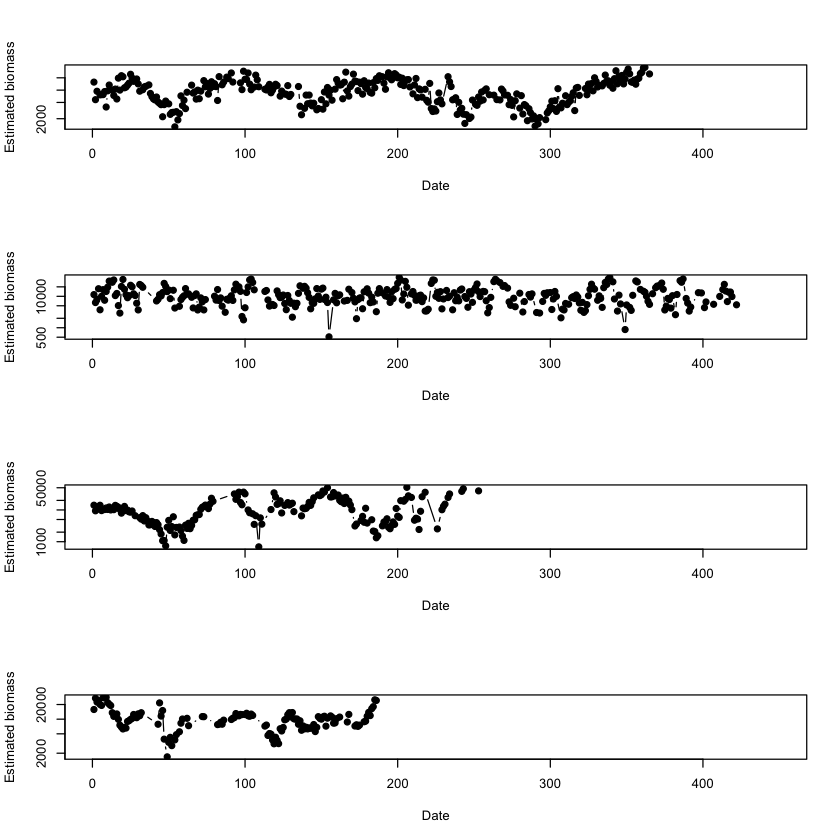

In [10]:
par(mfrow = c(4,1))
plot(x=metadata.da$measurementID,y=getbiomass(res.da), xlim=c(0, 450), type='b', pch=19, xlab='Date', ylab='Estimated biomass', log='y')
plot(x=metadata.m3$measurementID,y=getbiomass(res.m3), xlim=c(0, 450), type='b', pch=19, xlab='Date', ylab='Estimated biomass', log='y')
plot(x=metadata.db$measurementID,y=getbiomass(res.db), xlim=c(0, 450), type='b', pch=19, xlab='Date', ylab='Estimated biomass', log='y')
plot(x=metadata.f4$measurementID,y=getbiomass(res.f4), xlim=c(0, 450), type='b', pch=19, xlab='Date', ylab='Estimated biomass', log='y')

## Plot interaction network

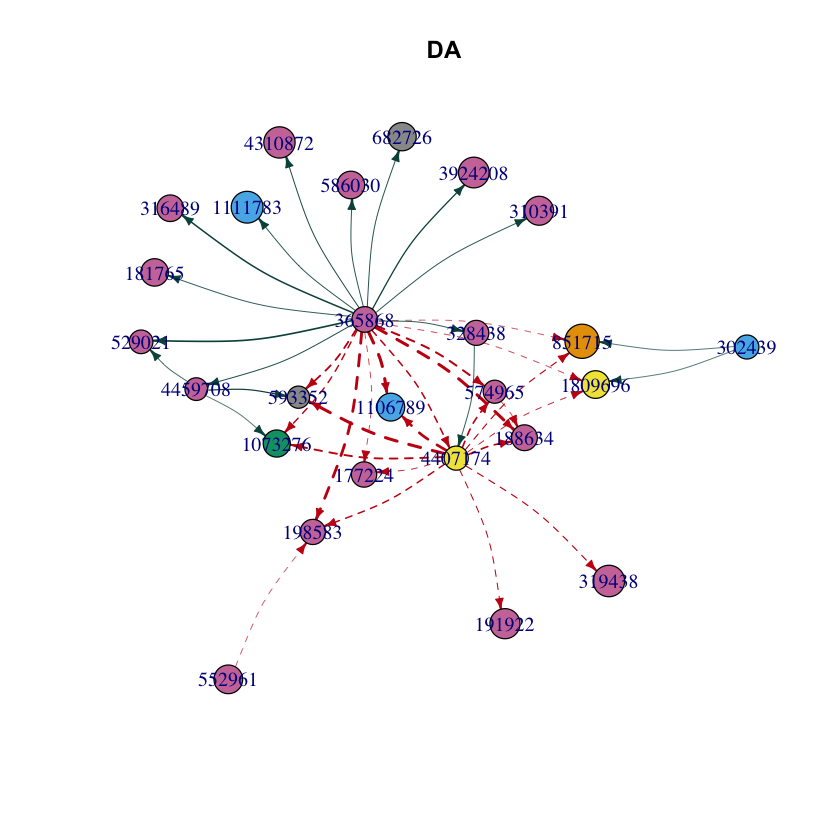

In [23]:
fill_cols <- pal_simpsons(c("springfield"))(16)
ga <- int.net(counts.da, params.da, 1.5, 'DA')

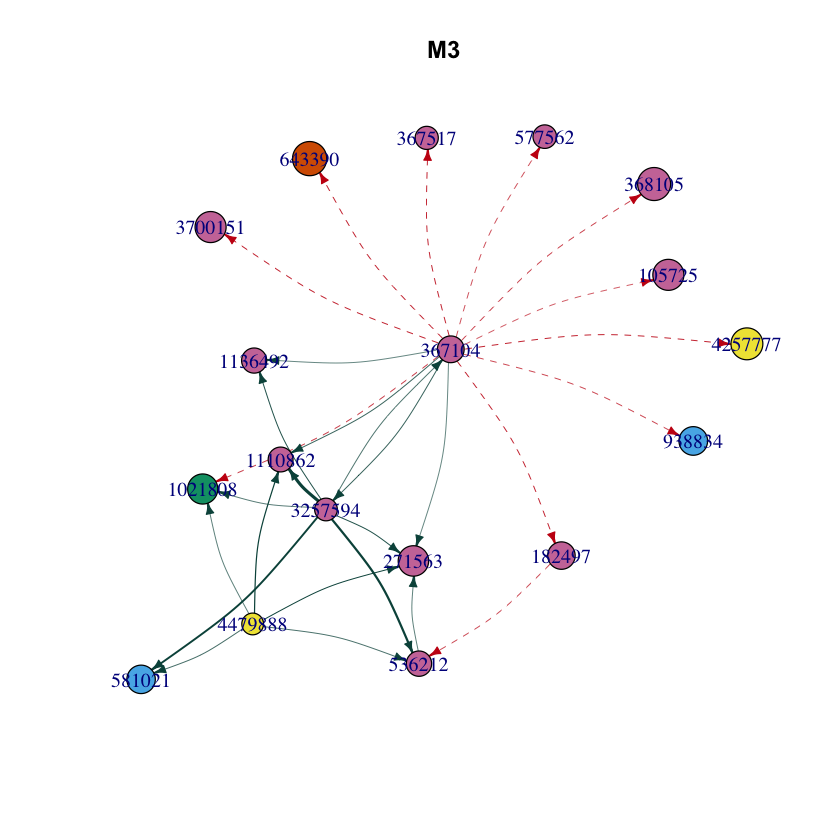

In [19]:
gm <- int.net(counts.m3, params.m3, 1.5, 'M3')

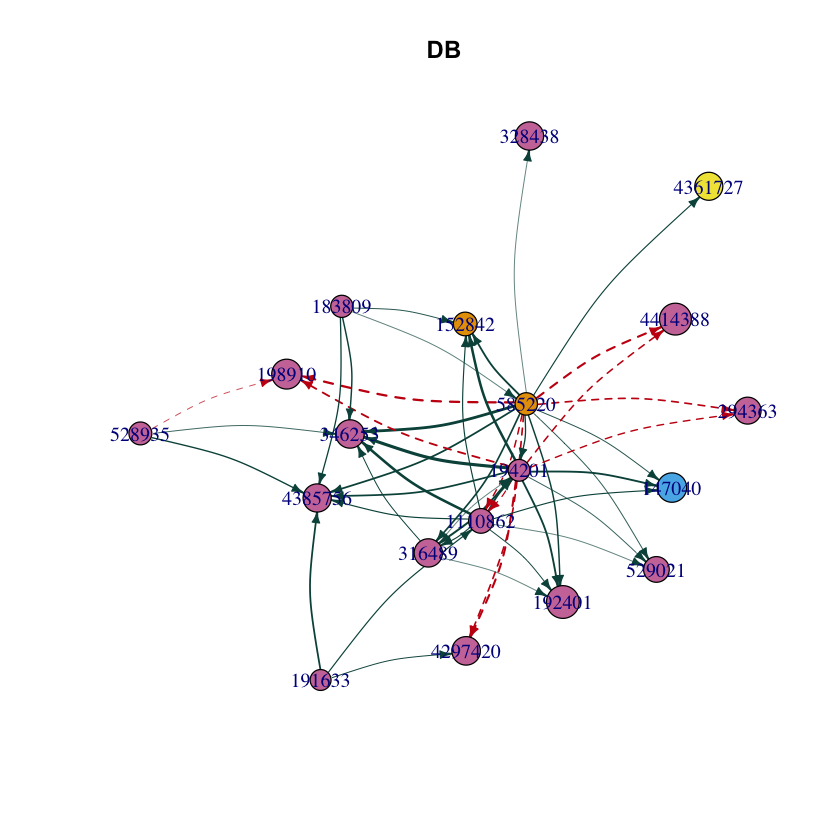

In [20]:
gb <- int.net(counts.db, params.db, 1.5, 'DB')

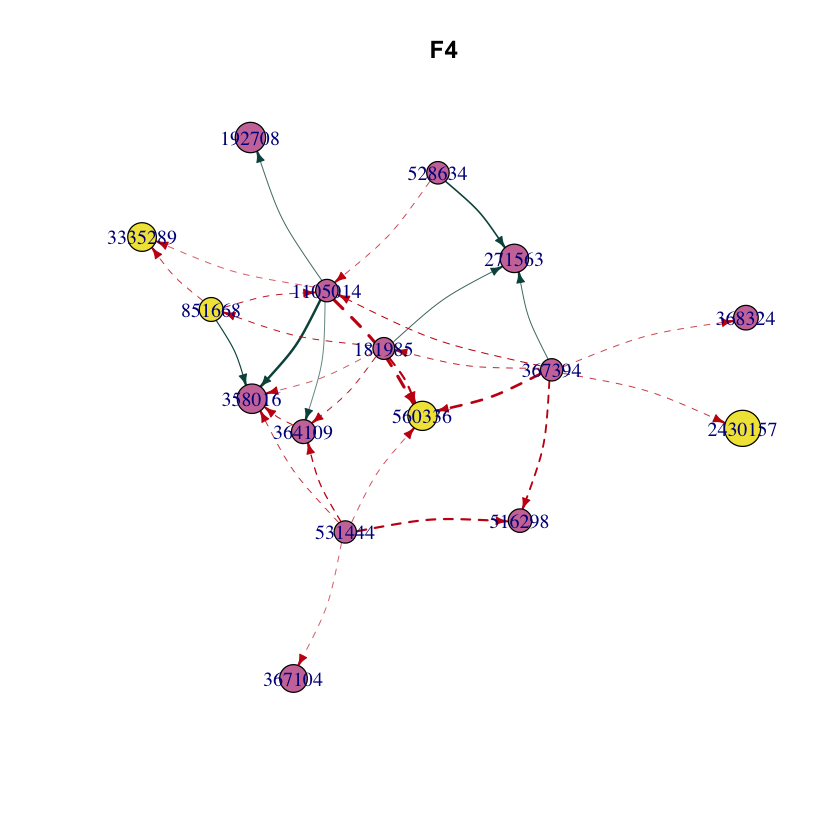

In [22]:
f4 <- int.net(counts.f4, params.f4, 1.5, 'F4')

In [24]:
res.da$counts <- counts.da
res.da$metadata <- metadata.da
saveRDS(res.da, '~/beem/time_series_analysis/DA.EM.rds')
write.table(params.da, '~/beem/time_series_analysis/DA.params.txt', col.names=TRUE, row.names=FALSE, sep='\t', quote=FALSE)

res.m3$counts <- counts.m3
res.m3$metadata <- metadata.m3
saveRDS(res.m3, '~/beem/time_series_analysis/M3.EM.rds')
write.table(params.m3, '~/beem/time_series_analysis/M3.params.txt', col.names=TRUE, row.names=FALSE, sep='\t', quote=FALSE)

res.db$counts <- counts.db
res.db$metadata <- metadata.db
saveRDS(res.db, '~/beem/time_series_analysis/DB.EM.rds')
write.table(params.db, '~/beem/time_series_analysis/DB.params.txt', col.names=TRUE, row.names=FALSE, sep='\t', quote=FALSE)

res.f4$counts <- counts.f4
res.f4$metadata <- metadata.f4
saveRDS(res.f4, '~/beem/time_series_analysis/F4.EM.rds')
write.table(params.f4, '~/beem/time_series_analysis/F4.params.txt', col.names=TRUE, row.names=FALSE, sep='\t', quote=FALSE)